# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

     |████████████████████████████████| 123 kB 7.0 MB/s 
     |████████████████████████████████| 90 kB 10.6 MB/s 
     |████████████████████████████████| 176 kB 37.9 MB/s 
     |████████████████████████████████| 131 kB 64.2 MB/s 
     |████████████████████████████████| 895 kB 62.9 MB/s 
     |████████████████████████████████| 1.2 MB 68.8 MB/s 
     |████████████████████████████████| 79 kB 10.9 MB/s 
     |████████████████████████████████| 7.8 MB 76.8 MB/s 
     |████████████████████████████████| 138 kB 95.4 MB/s 
     |████████████████████████████████| 127 kB 90.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatibl

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [6]:
!ls '/content/drive/MyDrive/Colab Notebooks/end2/data'

glove6B  glove.6B.zip  squad


In [7]:
import zipfile
trnsfile = '/content/drive/MyDrive/Colab Notebooks/end2/week15/pytorch-transformers-master.zip'

In [8]:
%cd '/content/drive/MyDrive/Colab Notebooks/end2/week15'

/content/drive/MyDrive/Colab Notebooks/end2/week15


In [9]:
with zipfile.ZipFile(trnsfile,"r") as zip_ref:
    zip_ref.extractall("/content/squad")

In [10]:
import sys
sys.path.append('/content/squad/pytorch-transformers-master/examples')
#sys.path.append('/drive/My Drive/Medium')

In [11]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
input_file ='/content/drive/MyDrive/Colab Notebooks/end2/data/squad/train-v2.0.json'  #'/drive/My Drive/Medium/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [14]:
len(examples)

130319

In [15]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [16]:
divideby = 12
train_size = len(examples)//divideby

In [17]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples[:train_size]])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [18]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
10452,56de326dcffd8e1900b4b65e,What type of buildings are are built mostly th...,"[It, is, widely, assumed, that, architectural,...",vernacular buildings,49,50,False
10453,56de326dcffd8e1900b4b660,Why did the economy begin to expand?,"[It, is, widely, assumed, that, architectural,...",a surplus in production,71,74,False
10454,56e47fc539bdeb1400347954,Through what process is it thought that the fi...,"[It, is, widely, assumed, that, architectural,...",trial and error,14,16,False
10455,56e47fc539bdeb1400347955,What is a popular type of architecture that st...,"[It, is, widely, assumed, that, architectural,...",vernacular,36,36,False
10456,56e47fc539bdeb1400347956,In what environment were many of the first hum...,"[It, is, widely, assumed, that, architectural,...",rural,68,68,False
10457,56e47fc539bdeb1400347957,What sort of an effect did a growing economy h...,"[It, is, widely, assumed, that, architectural,...",urbanization,82,82,False
10458,56e47fc539bdeb1400347958,At what speed did urban settlements sometimes ...,"[It, is, widely, assumed, that, architectural,...",rapidly,92,92,False
10459,5acfa1d377cf76001a68560c,What type of buildings are not built mostly th...,"[It, is, widely, assumed, that, architectural,...",,-1,-1,True
10460,5acfa1d377cf76001a68560d,Why did the economy stop expanding?,"[It, is, widely, assumed, that, architectural,...",,-1,-1,True
10461,5acfa1d377cf76001a68560e,Through what process is it thought that the fi...,"[It, is, widely, assumed, that, architectural,...",,-1,-1,True


In [19]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [20]:
print_squad_sample(train_data)

CONTEXT: 
There are technical limitations to archiving a web site, and as a consequence, it
is possible for opposing parties in litigation to misuse the results provided by web
site archives. This problem can be exacerbated by the practice of submitting screen shots
of web pages in complaints, answers, or expert witness reports, when the underlying links
are not exposed and therefore, can contain errors. For example, archives such as the
Wayback Machine do not fill out forms and therefore, do not include the contents
of non-RESTful e-commerce databases in their archives.
QUESTION:                                                                                            ANSWER:
What kind of limitations exist in keeping copies of a website?                                       technical
The omission of what element in screenshots can make them unreliable as evidence?                    underlying links
What elements of webpages are not used by Wayback Machine?                          

In [21]:

train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
6620,56d99e45dc89441400fdb60e,A natural camo pattern is known as what?,"[Domestic, dogs, often, display, the, remnants...",countershading,7,7,False,52,40
9765,5ad30688604f3c001a3fdada,Who is originally from the six deacons in the ...,"[Cardinal, deacons, derive, originally, from, ...",,-1,-1,True,55,62
9274,56ddead69a695914005b96b0,When was the Canadian Armed Forces name reintr...,"[After, the, 1980s,, the, use, of, the, ""Canad...",2013,24,24,False,25,53
6513,56db6621e7c41114004b5091,Because all five were in the top ten of Billbo...,"[American, Idol, has, traditionally, released,...",the most successful soundtrack franchise,55,59,False,131,80
3262,56d613011c85041400946eff,What Red Cross team left Taipei on May 16,"[A, direct, chartered, cargo, flight, was, mad...",rescue team,70,71,False,99,41


In [22]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.01086656229855%


In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 872369.95B/s]


In [24]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [25]:
cached_features_file ='/content/drive/MyDrive/Colab Notebooks/end2/week15/cache_train' # '/drive/My Drive/Medium/cache_train'

In [26]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [27]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [28]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [29]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [30]:
import glob
checkpoints = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/end2/week15/checkpoint/checkpoint*-[0-9]*'))

In [31]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [32]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/content/drive/MyDrive/Colab Notebooks/end2/week15/checkpoint/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

Loading model from checkpoint /content/drive/MyDrive/Colab Notebooks/end2/week15/checkpoint/checkpoint-9000


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [33]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0217,  0.0011,  0.0300,  ..., -0.0273,  0.0149,  0.0235],
        [ 0.0048, -0.0299,  0.0230,  ...,  0.0154,  0.0254, -0.0082]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0.0162, 0.0165], device='cuda:0', requires_grad=True))


In [34]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [35]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()
global_step = int(global_step)
for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      #print(type(step),type(global_step))
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/content/drive/MyDrive/Colab Notebooks/end2/week15/checkpoint/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 9016


Iteration:  97%|█████████▋| 8785/9016 [00:02<00:00, 3459.95it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)
Epoch: 100%|██████████| 1/1 [00:09<00:00,  9.27s/it]


In [36]:
output_dir = '/content/drive/MyDrive/Colab Notebooks/end2/week15/checkpoint/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
print("Saving model checkpoint to %s" % output_dir)

Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/end2/week15/checkpoint/checkpoint-final


In [37]:
train_loss_set_ckpt = torch.load('/content/drive/MyDrive/Colab Notebooks/end2/week15/checkpoint/checkpoint-final/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

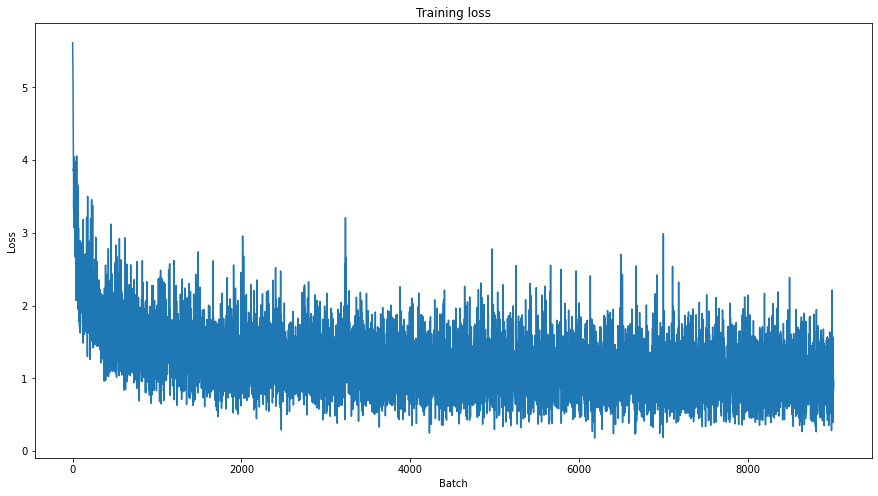

In [38]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [39]:
input_file = '/content/drive/MyDrive/Colab Notebooks/end2/data/squad/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)

In [40]:
#val_size = len(val_examples)//divideby

In [41]:

doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/content/drive/MyDrive/Colab Notebooks/end2/week15/cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [42]:
#features = features[:192]

In [43]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [44]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [45]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content/drive/MyDrive/Colab Notebooks/end2/data/squad/dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)
      #print(i , type(result)      )
  # Compute predictions
  output_prediction_file = "/content/drive/MyDrive/Colab Notebooks/end2/week15/predictions.json"
  output_nbest_file = "/content/drive/MyDrive/Colab Notebooks/end2/week15/nbest_predictions.json"
  output_null_log_odds_file = "/content/drive/MyDrive/Colab Notebooks/end2/week15/null_odds.json"
  output_dir = "/content/drive/MyDrive/Colab Notebooks/end2/week15/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [46]:
results = evaluate(model, tokenizer)

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16


Evaluating: 100%|██████████| 850/850 [02:01<00:00,  7.00it/s]


{
  "exact": 69.34220500294786,
  "f1": 72.38585584757419,
  "total": 11873,
  "HasAns_exact": 62.7361673414305,
  "HasAns_f1": 68.83219744909712,
  "HasAns_total": 5928,
  "NoAns_exact": 75.92935239697225,
  "NoAns_f1": 75.92935239697225,
  "NoAns_total": 5945,
  "best_exact": 69.6538364356102,
  "best_exact_thresh": -0.8769893646240234,
  "best_f1": 72.50951467430112,
  "best_f1_thresh": -0.4511709213256836
}


In [47]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 69.34220500294786}, {'f1': 72.38585584757419}, {'total': 11873}, {'HasAns_exact': 62.7361673414305}, {'HasAns_f1': 68.83219744909712}, {'HasAns_total': 5928}, {'NoAns_exact': 75.92935239697225}, {'NoAns_f1': 75.92935239697225}, {'NoAns_total': 5945}, {'best_exact': 69.6538364356102}, {'best_exact_thresh': -0.8769893646240234}, {'best_f1': 72.50951467430112}, {'best_f1_thresh': -0.4511709213256836}]


**Evaluate on any text**

In [48]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content/drive/MyDrive/Colab Notebooks/end2/data/squad/dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)
      print(i , type(result)      )
  # Compute predictions
  output_prediction_file = "/content/drive/MyDrive/Colab Notebooks/end2/week15/predictions.json"
  output_nbest_file = "/content/drive/MyDrive/Colab Notebooks/end2/week15/nbest_predictions.json"
  output_null_log_odds_file = "/content/drive/MyDrive/Colab Notebooks/end2/week15/null_odds.json"
  output_dir = "/content/drive/MyDrive/Colab Notebooks/end2/week15/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results



In [49]:
input_file ='/content/drive/MyDrive/Colab Notebooks/end2/data/squad/train-v2.0.json'  #'/drive/My Drive/Medium/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)